# Tutorial 1: The vertical density profile

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In this tutorial we will inspect the vertical density profile of the Milky Way. This will illustrate basic access of the Gaia data.

We use the TAP functionality in astroquery to collect Gaia DR2 data. This runs an ADQL query remotely and retrieves the data -- ADQL is like SQL with added functions to specifically querying astronomical datasets). You will get lots of warnings as astropy doesn't like the units used by Gaia -- I have switched these off with the warnings package. This query gets the top 100 stars with positive parallaxes and parallax/parallax_error>3. You can replace the ADQL query with your own ADQL query (see \href{https://gea.esac.esa.int/archive-help/adql/examples/index.html}{https://gea.esac.esa.int/archive-help/adql/examples/index.html} for some examples of Gaia ADQL queries.

To get the names of the columns, we have to look here https://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/

In [32]:
from astroquery.gaia import Gaia
job = Gaia.launch_job_async(
    "select top 100 * from gaiadr2.gaia_source "+
    "where parallax>0 and parallax_over_error>3. ") # Select `good' parallaxes

table = job.get_results()
print(table)

Query finished.
    solution_id             designation          ... epoch_photometry_url
                                                 ...                     
------------------- ---------------------------- ... --------------------
1635721458409799680 Gaia DR2 3665321345195491840 ...                   --
1635721458409799680 Gaia DR2 3665262933639854080 ...                   --
1635721458409799680 Gaia DR2 3665391473421016576 ...                   --
1635721458409799680 Gaia DR2 3665268847810309504 ...                   --
1635721458409799680 Gaia DR2 3665568907110130944 ...                   --
1635721458409799680 Gaia DR2 3665359969836446592 ...                   --
1635721458409799680 Gaia DR2 3665363298436254848 ...                   --
1635721458409799680 Gaia DR2 3665310040841426688 ...                   --
1635721458409799680 Gaia DR2 3665493384405764608 ...                   --
1635721458409799680 Gaia DR2 3665430750897562752 ...                   --
                ...   

We can access individual columns like this. Note the units.

In [3]:
print(table['pmra'])

        pmra        
      mas / yr      
--------------------
  -4.723500811005363
 -1.2166110665275116
  -2.552363253029383
   0.635310067557883
   7.183843236279285
  -3.546599888307931
  11.911708507626308
 -2.4256420035008754
-0.17462586774462907
 -3.9148021973513023
                 ...
  -4.938098907925836
  -6.335910962969821
 -3.6578054574670977
 -0.7909434760493024
 -3.8816262823174457
  -3.931825771742191
 -0.3983276159959158
  13.828522532510284
 -3.2895709286266417
 -5.0306145886236076
Length = 100 rows


We will now query some main sequence stars around the North Galactic Pole (Galactic latitude greater than $85\,\mathrm{deg}$). 
The ADQL language implements various mathematical functions. Here we are using log10. We require good parallaxes (not negative and with small errors -- this might bias our sample in funny ways but for now it is good enough). We select a small range in colours $0.65<(G_\mathrm{BP}-G_\mathrm{RP})<0.85$ and ensure they are main sequence by cutting on absolute magnitude. We don't worry about extinction as this effect is small when looking straight out of the disc.

In [4]:
from astroquery.gaia import Gaia
job = Gaia.launch_job_async(
    """select top 3000 phot_g_mean_mag,parallax """
    """from gaiadr2.gaia_source """
    """where b>85. """                              # Around North Galactic Pole
    """and parallax>0 and parallax_over_error>3. """# Select `good' parallaxes
    """and bp_rp>0.65 and bp_rp<0.85 """    # Select upper main sequence colours
    """and phot_g_mean_mag-5*log10(100./parallax) < 6.""") # Remove giant contaminants

table = job.get_results();

Query finished.


Another way to do this is using the ADQL built-in geometric functions. POINT is a function describing a point on the sky and BOX, POLYGON, CIRCLE are all functions that describe a region on the sky. Typically they are used in conjunction with CONTAINS. This will return True (1) is POINT is CONTAINed in CIRCLE. In theory these should work with Galactic coordinates but I can't get this to work. We therefore require the coordinates of the NGP, using astropy. In theory, using ra, dec is faster as the Gaia archive has been indexed on these entries.

In [5]:
from astropy.coordinates import SkyCoord, ICRS
import astropy.units as u
SkyCoord(l=300.*u.deg,b=90.*u.deg,frame='galactic').transform_to(ICRS)

<SkyCoord (ICRS): (ra, dec) in deg
    (192.85947789, 27.12825241)>

We then write the above query as 

In [6]:
from astroquery.gaia import Gaia
job = Gaia.launch_job_async(
    """select top 3000 phot_g_mean_mag,parallax """
    """from gaiadr2.gaia_source """
    """where 1=CONTAINS(POINT('ICRS',ra,dec),CIRCLE('ICRS',192.85947789, 27.12825241,5)) """ # Around North Galactic Pole
    """and parallax>0 and parallax_over_error>3. """# Select `good' parallaxes
    """and bp_rp>0.65 and bp_rp<0.85 """    # Select upper main sequence colours
    """and phot_g_mean_mag-5*log10(100./parallax) < 6.""") # Remove giant contaminants

table2 = job.get_results();

Query finished.


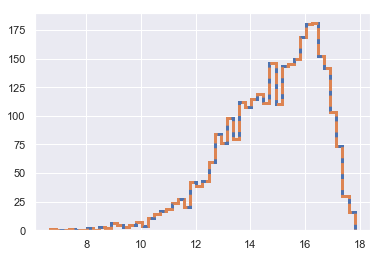

In [7]:
plt.hist(table2['phot_g_mean_mag'],histtype='step',lw=3,bins=50);
plt.hist(table['phot_g_mean_mag'],histtype='step',lw=3,bins=50,ls='dashed');

We have to worry about completeness. Gaia only observes down to a limiting magnitude. We can see in the magnitude distribution a truncation at around $16.3\,\mathrm{mag}$. For our selected main sequence stars (with median magnitude $4.3$) this corresponds to a limiting distance of $2.5\,\mathrm{kpc}$.

Limiting mag= 16.3 mag
Median absolute mag= 4.2873335323882 mag
Limiting distance= 2.5265813933891805 kpc


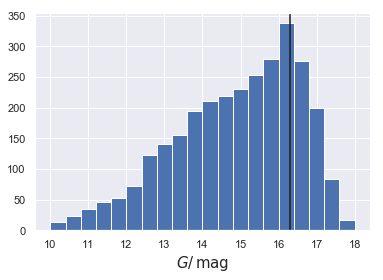

In [8]:
limiting_mag = 16.3 #
plt.axvline(limiting_mag,color='k')
plt.hist(table['phot_g_mean_mag'],range=[10.,18.],bins=20)
plt.xlabel(r'$G/\,\mathrm{mag}$')


Mv = np.median(table['phot_g_mean_mag']-5.*np.log10(100./table['parallax']))
limiting_distance = 10.**(0.2*(-Mv+limiting_mag)-2.)
print('Limiting mag=',limiting_mag,'mag')
print('Median absolute mag=',Mv,'mag')
print('Limiting distance=',limiting_distance,'kpc')

We have taken a sample in a cone. As such, there is a larger volume over which we observe distant stars than the volume over which we observe nearby stars. To compute the density with Galactic height we require a Jacobian factor. we denote distance $s$ and parallax $\varpi$.

$n(s) = s^2\rho(s)$

so $\rho(s) = \varpi^2 n(1/\varpi)$.

We have overplotted the classical thin/thick disc scaleheight exponentials. Note how beyond $s=2.5\,\mathrm{kpc}$ incompleteness is an issue.

Text(0.65, 400.0, 'Thin = 300pc')

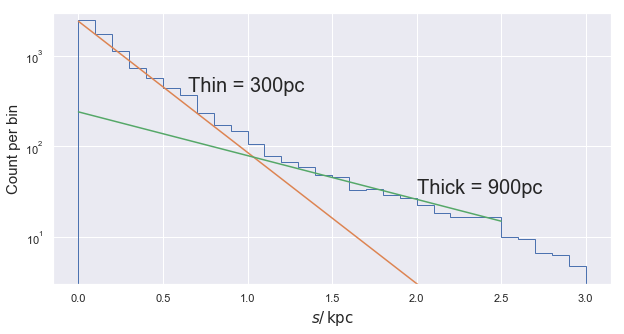

In [9]:
fig = plt.figure(figsize=[10.,5.])
xx = np.linspace(0.,2.5)
nbins=30
plt.hist(1./table['parallax'],range=[0.,3.],bins=nbins,
         weights=table['parallax']**2,histtype='step');
plt.ylim(0.001*len(table),1.*len(table))

thin_disc_scale_height=0.3
thick_disc_scale_height=0.9
scaling = len(table)/(1.*nbins)

plt.plot(xx,24.*scaling*np.exp(-xx/thin_disc_scale_height))
plt.plot(xx,2.4*scaling*np.exp(-xx/thick_disc_scale_height))

plt.semilogy()
plt.xlabel(r'$s/\,\mathrm{kpc}$')
plt.ylabel(r'Count per bin')
plt.annotate('Thick = 900pc', xy=(2.,.3*scaling),fontsize=20)
plt.annotate('Thin = 300pc', xy=(.65,4.*scaling),fontsize=20)

We have confirmed the Gilmore-Reid result for the thin-thick vertical structure of the disc (not quite as we were looking at the North Galactic Pole). The original result used photometric distances so it is not trivial to reproduce this result. Other things to do would be

1. Look at different samples (other main sequence cuts, giants, etc. -- see Bovy 2017 TGAS paper),

2. Look away from North Pole (can we map the full density field in parallaxes? -- reproducing Juric et al. 2008 but over whole sky)

3. Look at perturbations relative to the smooth model (see Bennett and Bovy, 2018).

## Joining with other tables
In addition to data in the Gaia DR2 source table, we might require additional data. Here we will grab results from the variability catalogue.

Query finished.


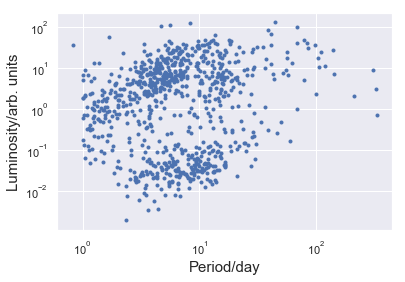

In [10]:
from astroquery.gaia import Gaia
job = Gaia.launch_job_async(
    """select top 1000 power(10.,-0.4*(phot_g_mean_mag-5.*log10(100./parallax))) as lum, pf as period """
    """from gaiadr2.gaia_source as G, gaiadr2.vari_cepheid as V where G.source_id=V.source_id """
    """and parallax_over_error>2."""
)
table3 = job.get_results();
plt.plot(table3['period'],table3['lum'],'.')
plt.semilogy()
plt.semilogx()
plt.xlabel('Period/day')
plt.ylabel('Luminosity/arb. units');

## Computing aggregate quantities

We can also compute aggregate quantities. Here we compute the mean, standard deviation (implemented specifically for the Gaia TAP+ service) and count for stars within 0.1 deg of the NGP.

In [11]:
from astroquery.gaia import Gaia
job = Gaia.launch_job_async(
    """select avg(bp_rp), stddev(bp_rp), count(*) """
    """from gaiadr2.gaia_source """
    """where 1=CONTAINS(POINT('ICRS',ra,dec),CIRCLE('ICRS',192.85947789, 27.12825241,0.1))""")
table3 = job.get_results();
print(table3)

Query finished.
       avg               stddev       count_all
------------------ ------------------ ---------
1.3012299208805478 0.6671705337696868        68


We can also compute averages binned by another column.

In [12]:
from astroquery.gaia import Gaia
job = Gaia.launch_job_async(
    """select avg(bp_rp) as mean_bprp, avg(pmra) as meanpmra, """
    """stddev(pmra) as std_pmra, count(*), round(bp_rp*5) as bin """
    """from gaiadr2.gaia_source """
    """where 1=CONTAINS(POINT('ICRS',ra,dec),CIRCLE('ICRS',192.85947789, 27.12825241,0.1)) """
    """group by bin order by bin"""
)
table3 = job.get_results();
print(table3)

Query finished.
     mean_bprp            meanpmra           std_pmra      count_all bin 
------------------- ------------------- ------------------ --------- ----
 0.2925529479980469  0.9967250993514118                 --         1  1.0
0.39504661560058596 -1.0437391618924852    1.3985565936889         5  2.0
 0.6297840118408203  -9.720657922224543 13.901853618271293         5  3.0
 0.8187069459394976  -5.403940264957905  9.735770728648967        11  4.0
 1.0233988080705916  -4.155133222253669  8.532296573983963         7  5.0
 1.2054602305094402 -17.024689929693437 3.9024275474255505         3  6.0
 1.4590363502502441 -12.840884089086014 16.691582183256596         4  7.0
 1.6041273389543806  -5.568259282869979  7.946967494249695         7  8.0
 1.8112707138061523  4.0610378898025985  7.313314913581323         2  9.0
 1.9614383697509765 -14.223314508195571  17.11847421314836         5 10.0
  2.191007614135742    4.63094220935661  4.932914063852677         2 11.0
 2.4071226119995117 -1

## Using Vizier

We can also use the TAP Vizier service. This is useful for cross-matching to other catalogues. Although, there are many cross-matches available in the Gaia arcive anyway.

In [13]:
from astroquery.utils.tap.core import TapPlus
tap = TapPlus(url="http://TAPVizieR.u-strasbg.fr/TAPVizieR/tap")
tables = tap.load_tables()

Created TAP+ (v1.0.1) - Connection:
	Host: TAPVizieR.u-strasbg.fr
	Use HTTPS: False
	Port: 80
	SSL Port: 443
Retrieving tables...
Parsing tables...
Done.


We have to find the name of the Gaia DR2 table in the Vizier database.

In [14]:
for t in tables:
    if 'gaia' in t.name:
        print(t.name)

"J/A+A/608/A148/origaia"
"I/337/gaia"
"I/345/gaia2"
"I/347/gaia2dis"


We now cross-match to LAMOST find Gaia stars within 1 arcsec (1/3600=0.00027777) of each LAMOST star.

In [21]:
job = tap.launch_job_async('select top 10 * from "I/345/gaia2" as gaia, '+
                           '"V/153/dr4" as lamost '+
                          "where 1=CONTAINS(POINT('ICRS',gaia.ra,gaia.dec),"+
                                           "CIRCLE('ICRS',lamost.raj2000,lamost.dej2000,0.00027777))")
tableV = job.get_results();
print(tableV)

Query finished.
        designation                ra       ra_error ... AssocData FileName
                                  deg         mas    ...                   
---------------------------- -------------- -------- ... --------- --------
Gaia DR2 3452892198312193152 93.94713989337   0.2115 ...      fits     fits
Gaia DR2 3452892198312193152 93.94713989337   0.2115 ...      fits     fits
Gaia DR2 3452892335751157504 93.90288808031   0.0323 ...      fits     fits
Gaia DR2 3452892438830368896 93.90882703471   0.0753 ...      fits     fits
Gaia DR2 3452892507549841920  93.9066007639   0.0324 ...      fits     fits
Gaia DR2 3452892679348521344  93.9447211398    0.056 ...      fits     fits
Gaia DR2 3452892679348521344  93.9447211398    0.056 ...      fits     fits
Gaia DR2 3452892778131053568 93.96622552691    0.039 ...      fits     fits
Gaia DR2 3452892954226422784 93.93449688216   0.0272 ...      fits     fits
Gaia DR2 3452893087375393536 93.95917993182   0.0243 ...      fits     f

In [22]:
tableV[['ObsID','RAJ2000','ra']]

ObsID,RAJ2000,ra
,deg,deg
int32,float64,float64
220504047,93.947134,93.94713989337
265104047,93.947134,93.94713989337
204804024,93.902888,93.90288808031
185904047,93.90881,93.90882703471
385304047,93.90658,93.9066007639
165104047,93.944752,93.9447211398
177304047,93.944756,93.9447211398
204804047,93.96622,93.96622552691


## Gaia RVS selection function

One other unique function provided in the Gaia archive is gaia_healpix_index which gives the healpix number of each Gaia source. Healpix are a method of dividing up the sphere into equal area pixels. This is useful as we can bin the catalogue by Healpix. In the following we count all sources in bins of G and healpix for a small region on the sky. 

In [27]:
from astroquery.gaia import Gaia
job = Gaia.launch_job_async(
    """select gaia_healpix_index(8, source_id) AS hpx8, count(*), round(phot_g_mean_mag*2.)/2 as G """
    """from gaiadr2.gaia_source """
    """where 1=CONTAINS(POINT('ICRS',ra,dec),CIRCLE('ICRS',50,50, 1.)) """
    """ and phot_g_mean_mag>6. and phot_g_mean_mag<17. """
    """group by hpx8, G order by G"""
)
table3 = job.get_results();
table3['gbin']=np.digitize(table3['g'],np.arange(6.,17.,0.5))
print(np.unique(table3['g']))

Query finished.
 g  
----
 7.0
 7.5
 8.0
 8.5
 9.0
 9.5
10.0
10.5
11.0
11.5
12.0
12.5
13.0
13.5
14.0
14.5
15.0
15.5
16.0
16.5
17.0


We plot with healpy.

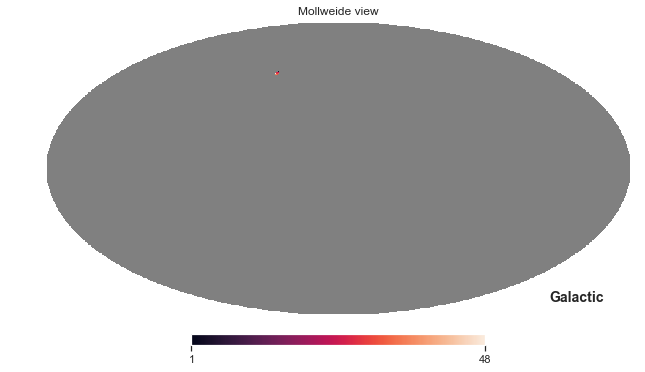

In [28]:
import healpy as hp
NSIDE = 256
Gbin=20
H = np.ones(hp.nside2npix(NSIDE))*np.nan
H[table3['hpx8'][table3['gbin']==Gbin]]=table3['count_all'][table3['gbin']==Gbin]
hp.mollview(H,nest=True,coord='G')

We perform the same calculation for those stars with radial velocities.

In [35]:
from astroquery.gaia import Gaia
job = Gaia.launch_job_async(
    """select gaia_healpix_index(8, source_id) AS hpx8, count(*), round(phot_g_mean_mag*2.)/2 as G """
    """from gaiadr2.gaia_source """
    """where 1=CONTAINS(POINT('ICRS',ra,dec),CIRCLE('ICRS',50,50, 1.)) """
    """ and phot_g_mean_mag>6. and phot_g_mean_mag<17. and radial_velocity>-1000 """
    """group by hpx8, G order by G"""
)
table3_RV = job.get_results();
table3_RV['gbin']=np.digitize(table3_RV['g'],np.arange(6.,17.,0.5))

Query finished.


Plotting the ratio we see the approx. selection function of the RVS in this part of the sky. Approx. complete up to G=13 mag.

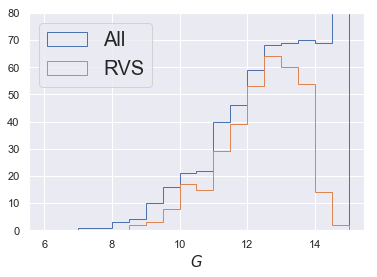

In [40]:
plt.hist(table3['g'],range=[6.,15.],bins=18,histtype='step',label='All')
plt.hist(table3_RV['g'],range=[6.,15.],bins=18,histtype='step',label='RVS')
plt.ylim(0.,80.)
plt.xlabel(r'$G$')
plt.legend(loc='upper left',fontsize=20);

Text(0, 0.5, 'Ratio RVS/All')

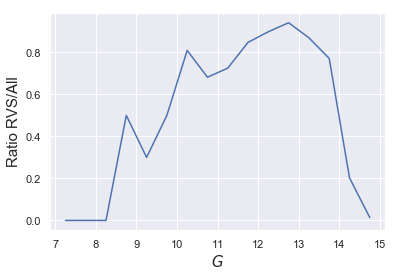

In [41]:
nn,bb = np.histogram(table3['g'],range=[6.,15.],bins=18)
nn2,bb = np.histogram(table3_RV['g'],bins=bb)
plt.plot(.5*(bb[1:]+bb[:-1]),nn2/nn)

plt.xlabel(r'$G$')
plt.ylabel(r'Ratio RVS/All')

# Other methods

## Reading downloaded VOT
Go to Gaia Archive (https://gea.esac.esa.int/archive/), query database, download vot (or other formats) and read in with astropy

In [ ]:
from astropy.table import Table
t = Table.read('/Users/jls/Downloads/1548744700623O-result.vot')
print(t)

## Use TOPCAT
Download http://www.star.bris.ac.uk/~mbt/topcat/, query TAP services, etc.

In [63]:
from astroquery.simbad import Simbad
result_table = Simbad.query_object("Hyades")
print(SkyCoord(ra='{}h{}m{}s'.format(*result_table['RA'][0].split(' ')), 
                  dec='{}d{}m{}s'.format(*result_table['DEC'][0].split(' '))))

<SkyCoord (ICRS): (ra, dec) in deg
    (66.725, 15.86666667)>
